In [49]:
import pandas as pd
import numpy as np

from DataPreparation import DataPreparation

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv('./data/balanced_dataframe.csv', index_col=None)
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,...,fr_Nhpyrrole,fr_aldehyde,fr_amidine,fr_aryl_methyl,fr_benzene,fr_benzodiazepine,fr_diazo,fr_halogen,fr_hdrzine,label
0,10.337455,-1.272753,23.375000,505.329,79.918731,10.123678,9.103951,-0.051090,3.459112,1.375036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.335047,-1.271941,23.375000,505.329,79.918731,10.124302,9.103026,-0.051090,3.450909,1.367373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,10.333078,-1.271281,23.375000,505.329,79.918731,10.124439,9.103025,-0.051090,3.448581,1.360843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10.355554,-1.235039,25.218750,440.504,16.562573,9.897992,5.825210,-0.051059,3.346646,1.323034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.090409,0.226017,12.285714,362.614,79.918731,10.103988,9.101988,0.552888,3.020157,1.976391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [51]:
X = df.drop(columns=['label'])
y = df['label']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y
                                                    )
# y_test.value_counts()

In [53]:
X_test.shape

(1830, 112)

In [54]:
data_preparation = DataPreparation(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = data_preparation.clean_dataset()

In [55]:
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix

In [56]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

In [57]:
svc = SVC(random_state=0)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
param_grid = {'C':[1, 10, 100],
                  'gamma':[0.01,0.001, 'auto', 'scale']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(svc, param_grid, cv=cv, scoring=scoring, refit='AUC', verbose=1, n_jobs=-1)

%time grid.fit(X_train, y_train)

print()
print(grid.best_params_)

y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_test, y_pred)
print("Mean ROC AUC:", score)

Fitting 30 folds for each of 12 candidates, totalling 360 fits
CPU times: user 1.11 s, sys: 136 ms, total: 1.25 s
Wall time: 1min 20s

{'C': 10, 'gamma': 'auto'}
Accuracy: 0.9765027322404372
Mean ROC AUC: 0.9765027322404373


In [58]:
y_pred = grid.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
cm = confusion_matrix(y_train, y_pred)
print("Accuracy:", accuracy)

score = roc_auc_score(y_train, y_pred)
print("Mean ROC AUC:", score)

Accuracy: 0.9978922716627635
Mean ROC AUC: 0.9978922716627635


In [59]:
from sklearn.decomposition import PCA

values = [i for i in range(1, X_train.shape[1]+1)]
print(values[0], values[-1])
train_scores = []
test_scores = []

for i in values:
    model = SVC(C=10, gamma=0.01)
    pca = PCA(n_components = i)
    pca_traindata = pca.fit(X_train)

    pcatrain = pca_traindata.transform(X_train)
    pcatest = pca_traindata.transform(X_test)

    model.fit(pcatrain, y_train)
    train_yhat = model.predict(pcatrain)
    train_acc = roc_auc_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(pcatest)
    test_acc = roc_auc_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plt.figure(1, figsize=(8,8))
# plt.plot(values, train_scores, '-o', label='Train')
# plt.plot(values, test_scores, '-o', label='Test')
# plt.legend()
# plt.xticks(range(1, 122, 10))
# plt.grid()
# plt.title('Support vector classifier')
# plt.ylabel('AUC')
# plt.xlabel('N components')
# plt.show()
# plt.savefig(f'{pics}/clf_dtree_balanced.png')

1 83
>1, train: 0.732, test: 0.737
>2, train: 0.841, test: 0.847
>3, train: 0.870, test: 0.864
>4, train: 0.878, test: 0.884
>5, train: 0.895, test: 0.895
>6, train: 0.922, test: 0.920
>7, train: 0.937, test: 0.939
>8, train: 0.943, test: 0.935
>9, train: 0.950, test: 0.943
>10, train: 0.952, test: 0.943
>11, train: 0.954, test: 0.946
>12, train: 0.956, test: 0.949
>13, train: 0.962, test: 0.955
>14, train: 0.963, test: 0.956
>15, train: 0.969, test: 0.957
>16, train: 0.972, test: 0.957
>17, train: 0.974, test: 0.961
>18, train: 0.975, test: 0.963
>19, train: 0.976, test: 0.962
>20, train: 0.981, test: 0.967
>21, train: 0.982, test: 0.969
>22, train: 0.983, test: 0.972
>23, train: 0.983, test: 0.972
>24, train: 0.985, test: 0.970
>25, train: 0.985, test: 0.971
>26, train: 0.986, test: 0.970
>27, train: 0.987, test: 0.973
>28, train: 0.987, test: 0.973
>29, train: 0.988, test: 0.972
>30, train: 0.988, test: 0.972


In [ ]:
X_train.shape

(4270, 83)

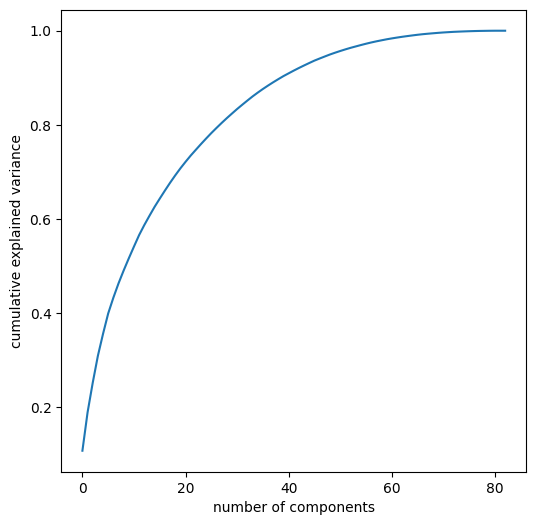

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 83)
pca_traindata = pca.fit(X_train)


pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(cum_ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
# plt.savefig(f'{pics}/pca.png')

In [ ]:
pca = PCA(n_components = 83)
pca_traindata = pca.fit(X_train)


pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

clf = SVC(C=10, gamma=0.01)

clf.fit(pcatrain, y_train)

train_preds = clf.predict(pcatrain)
print(roc_auc_score(y_train, train_preds))
test_preds = clf.predict(pcatest)
print(roc_auc_score(y_test, test_preds))

0.9969555035128806
0.9770491803278688


# Permutation feature importance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
clf = SVC(C=10, gamma=0.01)

clf.fit(X_train, y_train)

result = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=42, n_jobs=8)
perm_sorted_idx = result.importances_mean.argsort()

In [ ]:
train_preds = clf.predict(X_train)
print(roc_auc_score(y_train, train_preds))
test_preds = clf.predict(X_test)
print(roc_auc_score(y_test, test_preds))

0.9969555035128806
0.9770491803278688


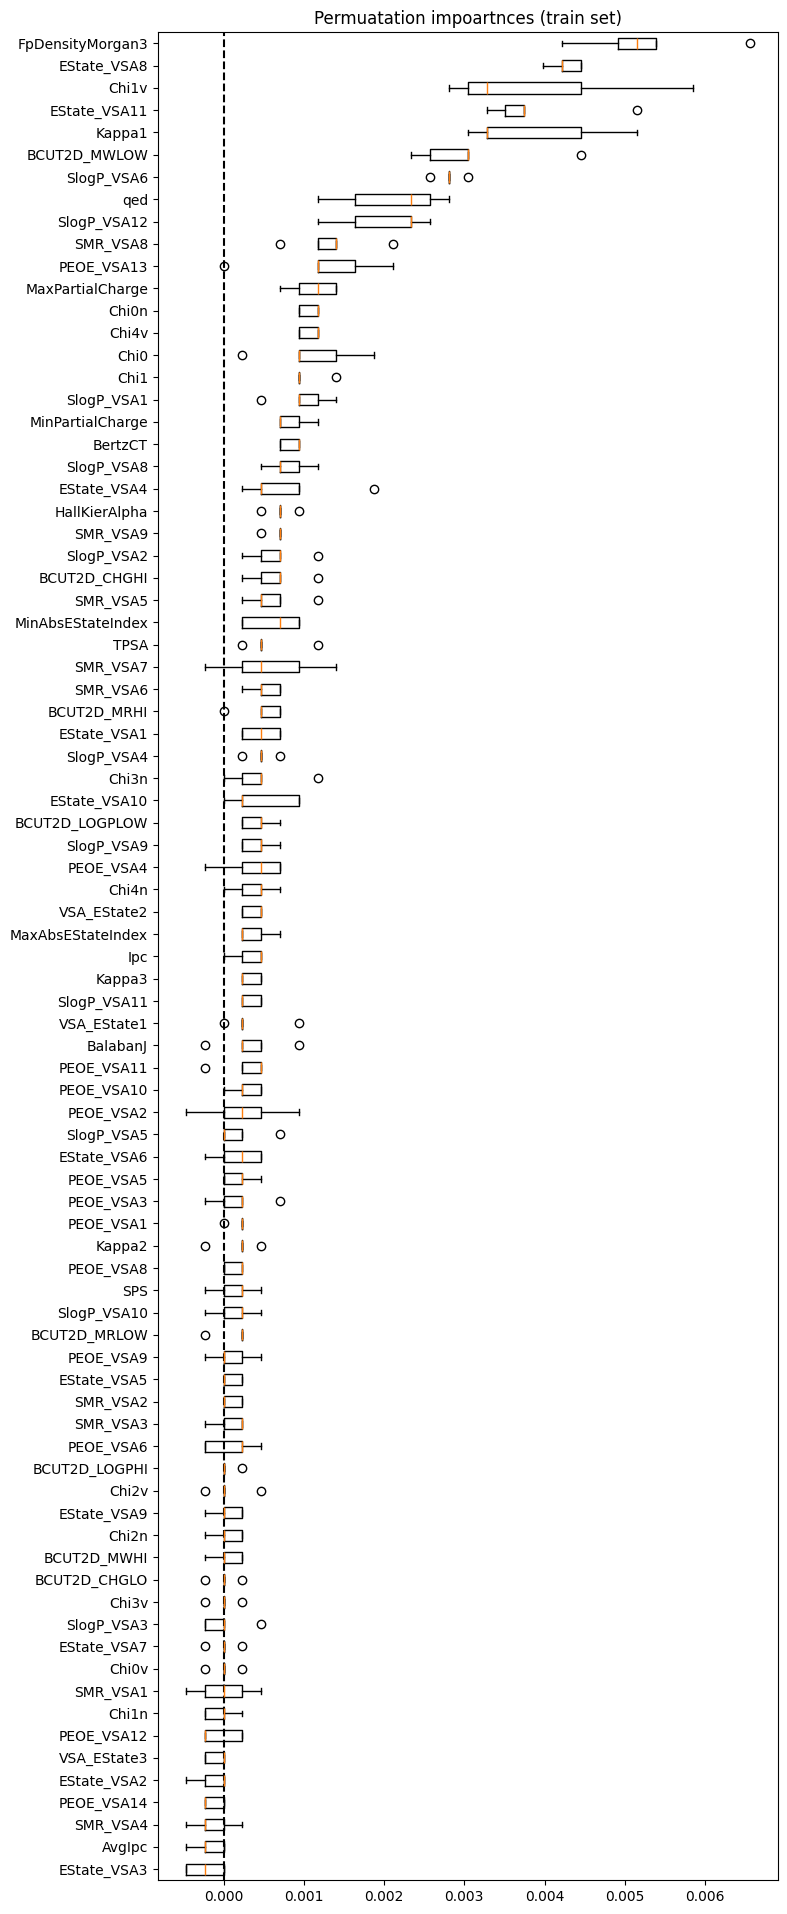

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 24))
plt.title('Permuatation impoartnces (train set)')
ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)
ax.axvline(x=0, color="k", linestyle="--")

In [ ]:
clf1 = SVC(C=10, gamma=0.01)
vals = X_train.columns[perm_sorted_idx]

clf1.fit(X_train[vals], y_train)

# result = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=42, n_jobs=8)
# perm_sorted_idx = result.importances_mean.argsort()
# perm_sorted_idx

train_preds = clf1.predict(X_train[vals])
print(roc_auc_score(y_train, train_preds))
test_preds = clf1.predict(X_test[vals])
print(roc_auc_score(y_test, test_preds))

0.9969555035128806
0.9770491803278688


In [ ]:
acc_train = []
acc_test = []
num_features = [i for i in range(1, len(perm_sorted_idx + 1))]

for i in num_features:
    clf1 = SVC(C=10, gamma=0.01)
    vals = X_train.columns[perm_sorted_idx[:i]]
    clf1.fit(X_train[vals], y_train)

# result = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=42, n_jobs=8)
# perm_sorted_idx = result.importances_mean.argsort()
# perm_sorted_idx
    train_preds = clf1.predict(X_train[vals])
    test_preds = clf1.predict(X_test[vals])
    

    acc_train.append(roc_auc_score(y_train, train_preds))
    acc_test.append(roc_auc_score(y_test, test_preds))

Text(0.5, 0.98, 'SVC predictions AUC depends on amount of features/components')

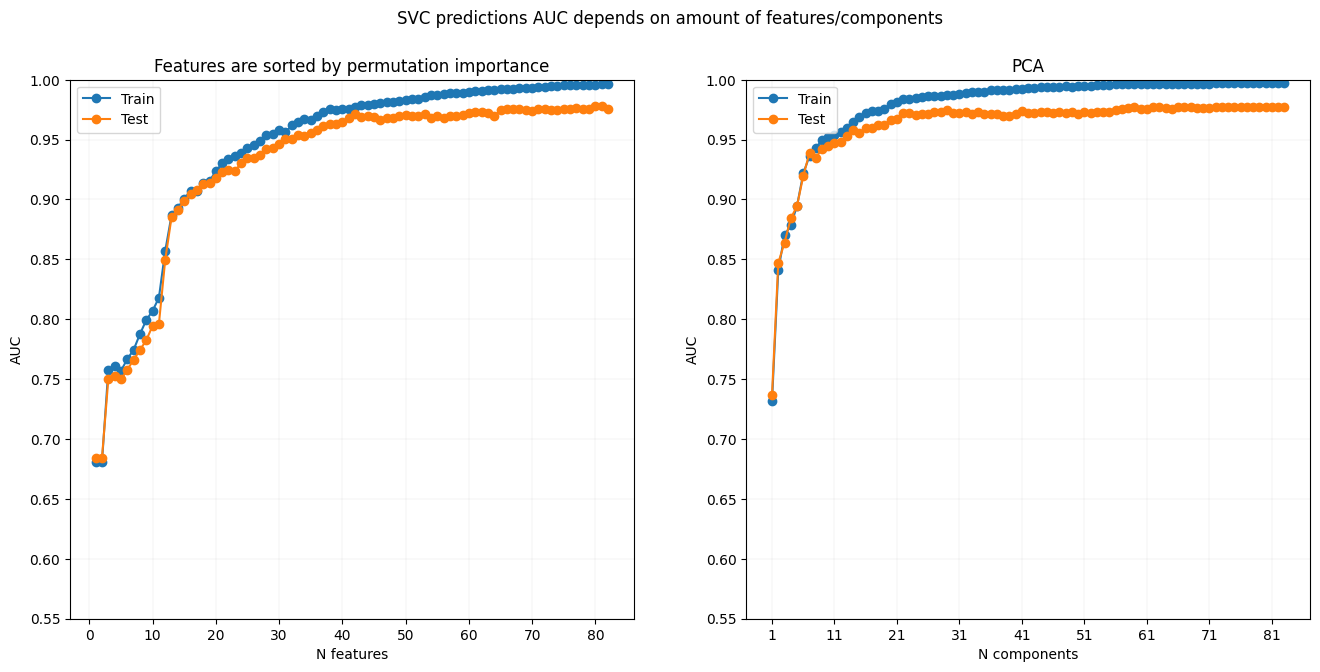

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ax1.set_xlim(left=0, right=5)
ax1.set_ylim(bottom=0.55, top=1)

ax1.plot(num_features, acc_train, '-o', label='Train')
ax1.plot(num_features, acc_test, '-o', label='Test')
ax1.legend()
plt.xticks(range(1, len(num_features), 10))
ax1.grid(lw=0.1)
ax1.set_title('Features are sorted by permutation importance')
ax1.set_ylabel('AUC')
ax1.set_xlabel('N features')

ax2.set_ylim(bottom=0.55, top=1)
ax2.plot(values, train_scores, '-o', label='Train')
ax2.plot(values, test_scores, '-o', label='Test')
ax2.legend()
plt.xticks(range(1, len(values), 10))
plt.grid(lw=0.1)
ax2.set_title('PCA')
ax2.set_ylabel('AUC')
ax2.set_xlabel('N components')
# plt.show()
plt.suptitle('SVC predictions AUC depends on amount of features/components')
# plt.savefig(f'{pics}/clf_dtree_balanced.png')